# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Problem Statement

This project is to build model to predict how the customer will respond to given offer based on demographics and offer type.Also will do data analysis and find out the performance of each offer.

## Strategy

I'll follow the following steps to solve the problem. First, Explore portfolio, profile, transcript datasets , clean them, then combine them. Each row in the combined dataset will have offers attributes, customer demographic data and offer is successful or not. Second,Evaluate the accuracy and F1 score of a naive model which assumes that all offer were sucessful.Then compare the performance of logistic regression and random forest models.

## Metrics

I'll evaluate model performance by using accuracy and F1 score metrics. Accuracy will measure how well a model correctly predicts wether the offer is successful. However, if the percentage of successful or unsuccessful offers is ver low, accuracy is not a good measure of model performance because of this I'll use also F1 score metric because it's a weighted average of the precision and recall metrics.

In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import  fbeta_score,make_scorer , accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import  RandomizedSearchCV,GridSearchCV
from sklearn.linear_model import LogisticRegression



# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
from sklearn.pipeline import Pipeline

## Data Exploration & Visualization

### portfolio

In [3]:
### get an idea about portfolio data
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
#shape of portfolio
portfolio.shape

(10, 6)

In [5]:
#get portfolio info
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [6]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [7]:
#check how many channel do we've
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [8]:
#create hist_plot function 
def hist_plot(data,title,xlabel,ylabel,v_range=(0,0)):
    '''
    this function to plot the histogram
    
    input: column data, title of graoh, xlabel & ylabel
    '''
    if v_range==(0,0):
        plt.hist(data)
    else:
        plt.hist(data,range=v_range)
   
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show


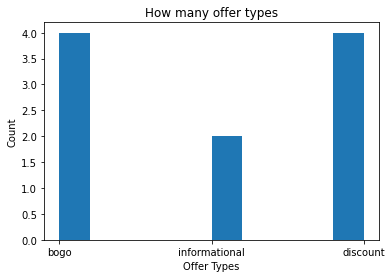

In [9]:
hist_plot(portfolio['offer_type'],'How many offer types','Offer Types','Count')

Text(0, 0.5, 'Count')

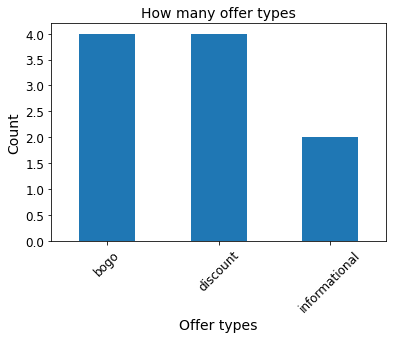

In [10]:

#plot the offer type
ax=portfolio['offer_type'].value_counts().plot.bar(rot=45,fontsize=12)
ax.set_title('How many offer types',fontsize=14) #set plot title
ax.set_xlabel('Offer types',fontsize=14)#set x label
ax.set_ylabel('Count',fontsize=14) #set y label

portfolio has 10 rows and 6 columns and there is no null values, it has web, email, mobile, social channels where offers are deployed , chnnels column need to be cleaned. also we've 3 offer types bogo,discount and informational.

### profile

In [11]:
#get an idea about profile data
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [12]:
#get profile shape
profile.shape

(17000, 5)

In [13]:
#get profile info
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [14]:
#get describe
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [15]:
#check unique values of gender
profile.gender.unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [16]:
# check unique value of age
profile.age.unique()

array([118,  55,  75,  68,  65,  58,  61,  26,  62,  49,  57,  40,  64,
        78,  42,  56,  33,  46,  59,  67,  53,  22,  96,  69,  20,  45,
        54,  39,  41,  79,  66,  29,  44,  63,  36,  76,  77,  30,  51,
        27,  73,  74,  70,  89,  50,  90,  60,  19,  72,  52,  18,  71,
        83,  43,  47,  32,  38,  34,  85,  48,  35,  82,  21,  24,  81,
        25,  37,  23, 100,  28,  84,  80,  87,  86,  94,  31,  88,  95,
        93,  91,  92,  98, 101,  97,  99])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='gender', ylabel='count'>

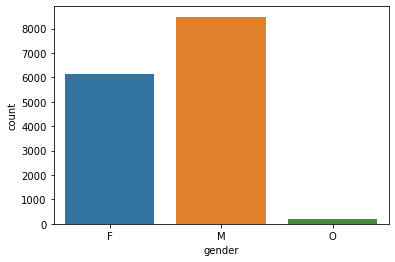

In [17]:
#gender Distribution 
sns.countplot(profile['gender'])

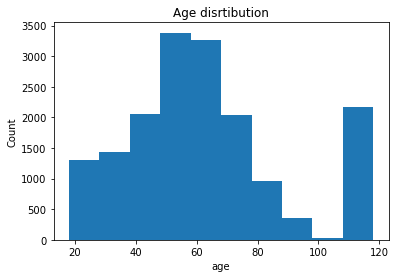

In [18]:

#plot age histogram
hist_plot(profile['age'],'Age disrtibution','age','Count')

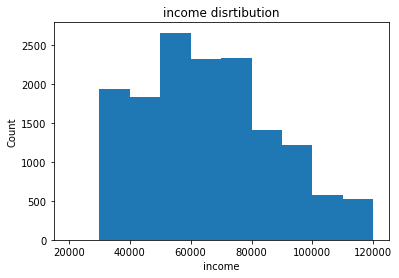

In [19]:
#plot income Distribution 
hist_plot(profile['income'],'income disrtibution','income','Count',(20000,120000))

From above, profile dataset has 17000 rows and 5 columns,there is null values in gender and income columns. from the above Distribution of gender that male is more than female, and from age Distribution the age group 50,60 are the highest. from income distribution member with income range from 50k-80k are higher than others.
this data set need to be cleaned since we've null values and age value of 118 seems to be data entry error.

### transcript

In [20]:
#get an idea how transcript data is look like
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [21]:
#get the shape of transcript
transcript.shape

(306534, 4)

In [22]:
#get info of transcript
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


## Data Wrangling

In [23]:
#Function to check null values
def null_checking(df,name):
    ''''
    this function to check null values in df
    
    input: 
    dataset df
    name : name of dataser
    '''
    df.name=name
    print('Null in ',df.name)
    size=len(df)
    for col in df.columns:
        null_count=df[col].isnull().sum()
        print('{} has {} % null values'.format(col,(null_count/size)*100))
    

In [24]:
#function to check duplicate values
def duplicate_checking(df,name):
    ''''
    this function to check duplicate values in df
    
    input: 
    dataset df
    name : name of dataser
    '''
    df.name=name
    print('duplicates in ',df.name)
    for col in df.columns: 
        #to avoid errror , check column type is not list or dict to find duplicates
        if type(df[col][0]) is not list and type(df[col][0]) is not dict:
            print('{} has {} rows duplicates'.format(col,df.duplicated(col).sum()))

In [25]:
#check null values in portfolio
null_checking(portfolio,'portfolio')

Null in  portfolio
reward has 0.0 % null values
channels has 0.0 % null values
difficulty has 0.0 % null values
duration has 0.0 % null values
offer_type has 0.0 % null values
id has 0.0 % null values


There is no null value in portfolio

In [26]:
# check duplicates value in portfolio
duplicate_checking(portfolio,'portfolio')

duplicates in  portfolio
reward has 5 rows duplicates
difficulty has 5 rows duplicates
duration has 5 rows duplicates
offer_type has 7 rows duplicates
id has 0 rows duplicates


In [27]:
#check null value in profile
null_checking(profile,'profile')

Null in  profile
gender has 12.794117647058822 % null values
age has 0.0 % null values
id has 0.0 % null values
became_member_on has 0.0 % null values
income has 12.794117647058822 % null values


gender & income has around 12% null value, since the percentage is small then we can remove null rows

In [28]:
# check duplicates value in portfolio
duplicate_checking(profile,'profile')

duplicates in  profile
gender has 16996 rows duplicates
age has 16915 rows duplicates
id has 0 rows duplicates
became_member_on has 15284 rows duplicates
income has 16908 rows duplicates


In [29]:
#check number of unique ids
profile.id.nunique()

17000

id is the key column and there is no duplicate in id

In [30]:
#check null value in transcript
null_checking(transcript,'transcript')

Null in  transcript
person has 0.0 % null values
event has 0.0 % null values
value has 0.0 % null values
time has 0.0 % null values


there is no null values in transcript

In [31]:
#check duplicates value in transcript columns
duplicate_checking(transcript,'transcript')

duplicates in  transcript
person has 289534 rows duplicates
event has 306530 rows duplicates
time has 306414 rows duplicates


In [32]:
#check number of unique person
transcript.person.nunique()

17000

In profile we've 17000 ids and same number of person on transcript

### Clean data

In [33]:
#make copy of all dataframes in order to clean them
profile_clean=profile
portfolio_clean=portfolio
transcript_clean=transcript

In [34]:
profile_clean=profile

### 1. profile data

◼ rename id column to member_id <br>
◼ change age value 118 to NaN <br>
◼ change became_member_on type to date<br>
◼ drop rows with null values (age , gender and income)<br>
◼ convert gender value to 0 and 1<br>
◼ define start_year, start_month columns from became_member_on <br>

In [35]:
# rename id column in profile to member_id
profile_clean=profile_clean.rename(columns={'id':'member_id'})

In [36]:
#make sure column name is changed
profile_clean.columns

Index(['gender', 'age', 'member_id', 'became_member_on', 'income'], dtype='object')

In [37]:
#check rows where age =118
profile_clean.where(profile_clean.age==118).count()

gender                 0
age                 2175
member_id           2175
became_member_on    2175
income                 0
dtype: int64

In [38]:
#change age value 118 to Nan
profile_clean.age.replace(118,np.nan,inplace=True)

In [39]:
#make sure age value 118 replaced with NaN
profile_clean.where(profile_clean.age==118).count()

gender              0
age                 0
member_id           0
became_member_on    0
income              0
dtype: int64

In [40]:
#change type of became_member_on
profile_clean.became_member_on=profile_clean['became_member_on'].astype(str).astype('datetime64[ns]')

In [41]:
# make sure type of became_member_on is changed
profile_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               14825 non-null  float64       
 2   member_id         17000 non-null  object        
 3   became_member_on  17000 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 664.2+ KB


In [42]:
print(len(profile_clean[profile_clean['gender'].isnull()]),len(profile_clean[profile_clean['age'].isnull()]),len(profile_clean[profile_clean['income'].isnull()]))

2175 2175 2175


In [43]:
#drop rows with null values of gender,age and income
profile_clean=profile_clean.drop(profile_clean[profile_clean['gender'].isnull()].index)

In [44]:
#make sure rows with null values of gender,age and income are removed
print(len(profile_clean[profile_clean['gender'].isnull()]),len(profile_clean[profile_clean['age'].isnull()]),len(profile_clean[profile_clean['income'].isnull()]))

0 0 0


In [45]:
# Convert gender values to numeric 0s and 1s
profile_clean['gender'] = profile_clean['gender'].apply(lambda x: 1 if x == 'M' else 0)

In [46]:
profile_clean.gender.unique()

array([0, 1])

In [47]:
gender_mapping=['F','M']

In [48]:
# profile: add start_year column
profile_clean['start_year'] = profile_clean.became_member_on.dt.year
profile_clean["start_month"] = profile_clean.became_member_on.dt.month

In [49]:
profile_clean

,gender,age,member_id,became_member_on,income,start_year,start_month
1,0,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7
3,0,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5
5,1,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,4
8,1,65.0,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,2
12,1,58.0,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,11
...,...,...,...,...,...,...,...
16995,0,45.0,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,2018,6
16996,1,61.0,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,2018,7
16997,1,49.0,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,2017,1
16998,0,83.0,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,2016,3


### 2. portfolio data

◼ rename id column to offer_id<br>
◼ one-hot encode channels <br>
◼ one-hot encode offer_type <br>

In [50]:
#rename id column to offer_id
portfolio_clean=portfolio_clean.rename(columns={'id':'offer_id'})

In [51]:
#make sure column name is changed
portfolio_clean.columns

Index(['reward', 'channels', 'difficulty', 'duration', 'offer_type',
       'offer_id'],
      dtype='object')

In [52]:
def hot_encode(df,col_list,col):
    ''''
    this function to one hot encode column
    
    input: df, column list and column need to apply one-hot encode
    output: df with multi columns
    '''
    for index,row in df.iterrows():
        for new_col in col_list:
            if new_col in df.loc[index,col]:
                df.loc[index,new_col]=1
            else:
                df.loc[index,new_col]=0
    return df


In [53]:
#one-hot encode channels
channel_list=['web','email','social','mobile']
portfolio_clean=hot_encode(portfolio_clean,channel_list,'channels')

In [54]:
#check the one-hot encode
portfolio_clean

,reward,channels,difficulty,duration,offer_type,offer_id,web,email,social,mobile
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1.0,1.0,1.0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1.0,1.0,0.0,1.0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,1.0,0.0,0.0
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0,1.0,1.0,1.0
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,1.0
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0.0,1.0,1.0,1.0
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,1.0
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,1.0


In [55]:
#remove channels column
portfolio_clean.drop(columns='channels',inplace=True)

In [56]:
#one-hot encode offer_type
offer_list=['bogo','informational','discount']
portfolio_clean=hot_encode(portfolio_clean,offer_list,'offer_type')

In [57]:
#check the one-hot encode
portfolio_clean

,reward,difficulty,duration,offer_type,offer_id,web,email,social,mobile,bogo,informational,discount
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1.0,1.0,1.0,1.0,0.0,0.0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0,1.0,0.0,0.0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,1.0,0.0,0.0,0.0,0.0,1.0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0,1.0,1.0,1.0,0.0,0.0,1.0
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,1.0,0.0,0.0,1.0
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0.0,1.0,1.0,1.0,0.0,1.0,0.0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,1.0,1.0,0.0,0.0
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,1.0,0.0,0.0,1.0


In [58]:
#remove offer_type column
portfolio_clean.drop(columns='offer_type',inplace=True)

In [59]:
#check the portfolio_clean
portfolio_clean

,reward,difficulty,duration,offer_id,web,email,social,mobile,bogo,informational,discount
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1.0,1.0,1.0,1.0,0.0,0.0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0,1.0,0.0,0.0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,1.0,0.0,0.0,0.0,0.0,1.0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0,1.0,1.0,1.0,0.0,0.0,1.0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,1.0,0.0,0.0,1.0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,0.0,1.0,1.0,1.0,0.0,1.0,0.0
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,1.0,1.0,0.0,0.0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,1.0,0.0,0.0,1.0


### 3. Transcript

◼ rename person column to member_id <br>
◼ split value column to offer_id and amount<br>
◼ drop value column <br>
◼ remove rows where person is not available in profile <br>
◼ convert time column to days<br>
◼ remove duplicate if exist<br>
◼ assign offer_id to transaction rows and delete transaction where offer id is null

In [60]:
#rename person column in transcript to member_id
transcript_clean=transcript_clean.rename(columns={'person':'member_id'})

In [61]:
#make sure column name is changed
transcript_clean.columns

Index(['member_id', 'event', 'value', 'time'], dtype='object')

In [62]:
#split value column to offer_id and amount
transcript_clean=pd.concat([transcript_clean,transcript_clean['value'].apply(pd.Series)],axis=1)

In [63]:
transcript_clean.head()

,member_id,event,value,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [64]:
# we've duplicated offer_id column (offer id and offer_id) and we need to merge them into one column
transcript_clean['new_offer_id']=np.where(transcript_clean['offer id'].isnull() & transcript_clean['offer_id'].notnull(),transcript_clean['offer_id'],
                                         transcript_clean['offer id'])
#remove the offer_id and offer id column
transcript_clean.drop(['offer_id','offer id'], axis=1,inplace=True)

#rename the new_offer_id column to offer_id
transcript_clean=transcript_clean.rename(columns={'new_offer_id':'offer_id'})

In [65]:
#check change is implemented
transcript_clean.head(3)

,member_id,event,value,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5


In [66]:
transcript_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   member_id  306534 non-null  object 
 1   event      306534 non-null  object 
 2   value      306534 non-null  object 
 3   time       306534 non-null  int64  
 4   amount     138953 non-null  float64
 5   reward     33579 non-null   float64
 6   offer_id   167581 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 16.4+ MB


In [67]:
#drop value column
transcript_clean.drop(['value'], axis=1,inplace=True)

In [68]:
transcript_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   member_id  306534 non-null  object 
 1   event      306534 non-null  object 
 2   time       306534 non-null  int64  
 3   amount     138953 non-null  float64
 4   reward     33579 non-null   float64
 5   offer_id   167581 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 14.0+ MB


In [69]:
#check change is implemented
transcript_clean.head(3)

,member_id,event,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5


In [70]:
#remove rows where person is not available in profile
transcript_clean=transcript_clean[transcript_clean.member_id.isin(profile_clean.member_id)]

In [71]:
#convert time column to days
transcript_clean['time'] /=24

In [72]:
transcript_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 306532
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   member_id  272762 non-null  object 
 1   event      272762 non-null  object 
 2   time       272762 non-null  float64
 3   amount     123957 non-null  float64
 4   reward     32444 non-null   float64
 5   offer_id   148805 non-null  object 
dtypes: float64(3), object(3)
memory usage: 14.6+ MB


In [73]:
#check duplicated value
transcript_clean.duplicated().sum()

374

In [74]:
#drop duplicated value
transcript_clean.drop_duplicates(inplace=True)
transcript_clean.reset_index(drop=True, inplace=True)

In [75]:
transcript_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272388 entries, 0 to 272387
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   member_id  272388 non-null  object 
 1   event      272388 non-null  object 
 2   time       272388 non-null  float64
 3   amount     123957 non-null  float64
 4   reward     32070 non-null   float64
 5   offer_id   148431 non-null  object 
dtypes: float64(3), object(3)
memory usage: 12.5+ MB


In [76]:
#check unique value of event
transcript_clean.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [77]:
transcript_clean.head()


,member_id,event,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,e2127556f4f64592b11af22de27a7932,offer received,0.0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
2,389bc3fa690240e798340f5a15918d5c,offer received,0.0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0.0,NaN,NaN,3f207df678b143eea3cee63160fa8bed
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0.0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [78]:
transcript_clean.shape

(272388, 6)

In [79]:
# check events value counts in transcript_clean
transcript_clean.event.value_counts()

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32070
Name: event, dtype: int64

Text(0.5, 1.0, 'Membership start year by gender')

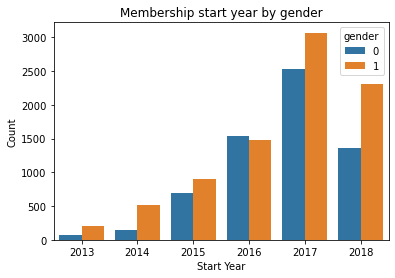

In [80]:
member_df=profile_clean.groupby(['start_year','gender']).size()
member_df=member_df.reset_index()
member_df=member_df.rename(columns={0:'count'})
sns.barplot(x='start_year',y='count',hue='gender',data=member_df)
plt.xlabel('Start Year')
plt.ylabel('Count')
plt.title('Membership start year by gender')


Above shows that most customers(members) joined the starbucks program  2017. Also male member number has been increased in each year.

In [81]:
profile_clean.head()

,gender,age,member_id,became_member_on,income,start_year,start_month
1,0,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7
3,0,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5
5,1,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,4
8,1,65.0,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,2
12,1,58.0,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,11


In [82]:
#calculate event type disribution
event_count=transcript_clean['event'].value_counts()
event_count

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32070
Name: event, dtype: int64

In [83]:
#Calculate percentage of transactions and offers events
total_event=event_count.sum()
print('transaction percentage is',100*event_count[0]/total_event,'offer percentage is ',100*event_count[1:].sum()/total_event)

transaction percentage is 45.507511344112075 offer percentage is  54.492488655887925


#### ◼ Event ditribution by Gender

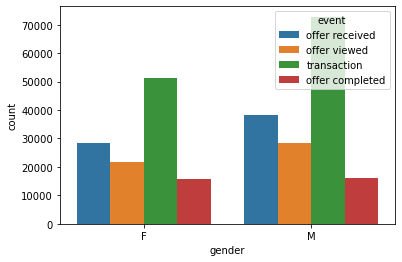

In [84]:
g=sns.countplot(x='gender',hue='event',data=transcript_clean.merge(profile_clean,on='member_id'))
xlabels=gender_mapping
g.set_xticklabels(xlabels)
plt.show()

In [85]:
#sort the data by member_id,time & offer id
transcript_clean.sort_values(['member_id','time','offer_id'],inplace=True)

In [86]:
transcript_clean

,member_id,event,time,amount,reward,offer_id
49809,0009655768c64bdeb2e877511632db8f,offer received,7.00,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
68952,0009655768c64bdeb2e877511632db8f,offer viewed,8.00,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
79386,0009655768c64bdeb2e877511632db8f,transaction,9.50,22.16,NaN,NaN
101111,0009655768c64bdeb2e877511632db8f,offer received,14.00,NaN,NaN,3f207df678b143eea3cee63160fa8bed
124364,0009655768c64bdeb2e877511632db8f,offer viewed,15.50,NaN,NaN,3f207df678b143eea3cee63160fa8bed
...,...,...,...,...,...,...
229306,ffff82501cea40309d5fdd7edcca4a07,offer completed,24.00,NaN,2.0,2906b810c7d4411798c6938adc9daaa5
229305,ffff82501cea40309d5fdd7edcca4a07,transaction,24.00,14.23,NaN,NaN
232910,ffff82501cea40309d5fdd7edcca4a07,offer viewed,24.25,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
243915,ffff82501cea40309d5fdd7edcca4a07,transaction,25.25,10.12,NaN,NaN


In [87]:
#check number of event for each offer
transcript_clean.groupby(['offer_id','event']).event.count()

offer_id                          event          
0b1e1539f2cc45b7b9fa7c272da2e1d7  offer completed    3306
                                  offer received     6726
                                  offer viewed       2215
2298d6c36e964ae4a3e7e9706d1fb8c2  offer completed    4847
                                  offer received     6655
                                  offer viewed       6379
2906b810c7d4411798c6938adc9daaa5  offer completed    3860
                                  offer received     6631
                                  offer viewed       3460
3f207df678b143eea3cee63160fa8bed  offer received     6657
                                  offer viewed       3487
4d5c57ea9a6940dd891ad53e9dbe8da0  offer completed    3281
                                  offer received     6593
                                  offer viewed       6329
5a8bc65990b245e5a138643cd4eb9837  offer received     6643
                                  offer viewed       5873
9b98b8c7a33c4b65b9aebf

offers with following ids (3f207df678b143eea3cee63160fa8bed, 3f207df678b143eea3cee63160fa8bed) had only 3 events 
offer received, offer viewed and transaction those offers are informational while others had offer received, offer 
viewed ,transaction and offer completed

I found also that transaction had no offer assign to it, and in order to check if the informational offer is completed I'll try to assign offer_id to transaction by following below steps:

In [88]:
#since data is sorted by member_id, time and offer id, I'll shift the offer id from following row if they are for similar member
transcript_clean['tran_offer_id']=transcript_clean['offer_id'].shift(1)


In [89]:
#assign nan to tran_offer_id if member_id is different
transcript_clean.loc[transcript_clean['member_id'].shift(-1)!=transcript_clean['member_id'],['tran_offer_id']]=np.nan

In [90]:
transcript_clean.head(10)

,member_id,event,time,amount,reward,offer_id,tran_offer_id
49809,0009655768c64bdeb2e877511632db8f,offer received,7.00,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
68952,0009655768c64bdeb2e877511632db8f,offer viewed,8.00,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837
79386,0009655768c64bdeb2e877511632db8f,transaction,9.50,22.16,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
101111,0009655768c64bdeb2e877511632db8f,offer received,14.00,NaN,NaN,3f207df678b143eea3cee63160fa8bed,NaN
124364,0009655768c64bdeb2e877511632db8f,offer viewed,15.50,NaN,NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed
136355,0009655768c64bdeb2e877511632db8f,offer received,17.00,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,3f207df678b143eea3cee63160fa8bed
149504,0009655768c64bdeb2e877511632db8f,offer completed,17.25,NaN,5.0,f19421c1d4aa40978ebb69ca19b0e20d,f19421c1d4aa40978ebb69ca19b0e20d
149503,0009655768c64bdeb2e877511632db8f,transaction,17.25,8.57,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
166644,0009655768c64bdeb2e877511632db8f,offer viewed,19.00,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
181620,0009655768c64bdeb2e877511632db8f,offer received,21.00,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,f19421c1d4aa40978ebb69ca19b0e20d


In [91]:
transcript_clean.tail(10)

,member_id,event,time,amount,reward,offer_id,tran_offer_id
180427,ffff82501cea40309d5fdd7edcca4a07,offer received,21.00,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
190659,ffff82501cea40309d5fdd7edcca4a07,offer completed,21.00,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98b8c7a33c4b65b9aebfe6a799e6d9
190658,ffff82501cea40309d5fdd7edcca4a07,transaction,21.00,7.79,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
204794,ffff82501cea40309d5fdd7edcca4a07,offer viewed,22.25,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
218923,ffff82501cea40309d5fdd7edcca4a07,offer received,24.00,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,9b98b8c7a33c4b65b9aebfe6a799e6d9
229306,ffff82501cea40309d5fdd7edcca4a07,offer completed,24.00,NaN,2.0,2906b810c7d4411798c6938adc9daaa5,2906b810c7d4411798c6938adc9daaa5
229305,ffff82501cea40309d5fdd7edcca4a07,transaction,24.00,14.23,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
232910,ffff82501cea40309d5fdd7edcca4a07,offer viewed,24.25,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
243915,ffff82501cea40309d5fdd7edcca4a07,transaction,25.25,10.12,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
257504,ffff82501cea40309d5fdd7edcca4a07,transaction,27.00,18.91,NaN,NaN,NaN


In [92]:
#assign offer id  to transaction row 
transcript_clean['offer_id']=np.where(transcript_clean['offer_id'].notnull()  ,transcript_clean['offer_id']
                               ,transcript_clean['tran_offer_id'])

In [93]:
#drop the temporary columns tran_offer_id
transcript_clean.drop(columns=['tran_offer_id'],inplace=True)

In [94]:
transcript_clean.head()

,member_id,event,time,amount,reward,offer_id
49809,0009655768c64bdeb2e877511632db8f,offer received,7.0,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
68952,0009655768c64bdeb2e877511632db8f,offer viewed,8.0,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
79386,0009655768c64bdeb2e877511632db8f,transaction,9.5,22.16,NaN,5a8bc65990b245e5a138643cd4eb9837
101111,0009655768c64bdeb2e877511632db8f,offer received,14.0,NaN,NaN,3f207df678b143eea3cee63160fa8bed
124364,0009655768c64bdeb2e877511632db8f,offer viewed,15.5,NaN,NaN,3f207df678b143eea3cee63160fa8bed


In [95]:
null_checking(transcript_clean,'transcript_clean')

Null in  transcript_clean
member_id has 0.0 % null values
event has 0.0 % null values
time has 0.0 % null values
amount has 54.492488655887925 % null values
reward has 88.22635358385831 % null values
offer_id has 24.83956708812429 % null values


In [96]:
#Check number of rows which has null offer_id 
transcript_clean.offer_id.isnull().sum()

67660

In [97]:
#drop rows which has null value in transactions
transcript_clean.dropna(subset=['offer_id'],inplace=True)

In [98]:
#check number of rows which has offer_id
transcript_clean.offer_id.notnull().sum()

204728

In [99]:
#Combine the 3 datasets into one
master_data=pd.merge(pd.merge(transcript_clean,portfolio_clean,on='offer_id',how='left'),profile_clean,on='member_id')

In [100]:
master_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204728 entries, 0 to 204727
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   member_id         204728 non-null  object        
 1   event             204728 non-null  object        
 2   time              204728 non-null  float64       
 3   amount            56297 non-null   float64       
 4   reward_x          32070 non-null   float64       
 5   offer_id          204728 non-null  object        
 6   reward_y          204728 non-null  int64         
 7   difficulty        204728 non-null  int64         
 8   duration          204728 non-null  int64         
 9   web               204728 non-null  float64       
 10  email             204728 non-null  float64       
 11  social            204728 non-null  float64       
 12  mobile            204728 non-null  float64       
 13  bogo              204728 non-null  float64       
 14  info

In [101]:
#create one column of reward and fill it with data from reward_x and reward_y
master_data['reward']=np.where(master_data['reward_x'].notnull() & master_data['reward_y'].isnull(),master_data['reward_x']
                               ,master_data['reward_y'])

In [102]:
#drop unneccessary columns reward_x, reward_y 
master_data.drop(columns=['reward_x','reward_y'],inplace=True)

In [103]:
master_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204728 entries, 0 to 204727
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   member_id         204728 non-null  object        
 1   event             204728 non-null  object        
 2   time              204728 non-null  float64       
 3   amount            56297 non-null   float64       
 4   offer_id          204728 non-null  object        
 5   difficulty        204728 non-null  int64         
 6   duration          204728 non-null  int64         
 7   web               204728 non-null  float64       
 8   email             204728 non-null  float64       
 9   social            204728 non-null  float64       
 10  mobile            204728 non-null  float64       
 11  bogo              204728 non-null  float64       
 12  informational     204728 non-null  float64       
 13  discount          204728 non-null  float64       
 14  gend

In [104]:
profile_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  int64         
 1   age               14825 non-null  float64       
 2   member_id         14825 non-null  object        
 3   became_member_on  14825 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
 5   start_year        14825 non-null  int64         
 6   start_month       14825 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 926.6+ KB


In [105]:
from tqdm import tqdm

Bogo & discount offers follow the following steps: offer recieved => offer viewed => offer completed while informational offer follow : offer recieved => offer viewed => transaction.<br>
I'll create 2 datasets to define the offer_successfull variable one for bogo & discount , the other one for informational then I'll combine both datasets.

In [106]:
def define_offer_successful(df):
    '''
    this function to check and assign value to offer_successful varibale
    
    input: df
    output: customer_offers_other dataframe which include offer_successful column
    '''
    # #create dataframes for offer received, viewed, completed & transaction
    offers_other = []
    offer_received_other= df[df.event == 'offer received']
    offers_viewed_other = df[df.event == 'offer viewed']
    offers_completed_other = df[df.event == 'offer completed']
    transactions_other = df[df.event == 'transaction']
    
    offer_successfull=0
#    print('SHAPE',offers_completed_other.shape[0])


    for index, offer in tqdm(offer_received_other.iterrows()):
        
        customer_id = offer.member_id
        start_time = int(offer.time)
        end_time = int(start_time + offer.duration)

  
    #transaction happen within offer valid time  
        tran_valid_time=transactions_other['time'].between(start_time,end_time)
    

    
    #transaction happen within offer valid time    
        transaction_amount=transactions_other[(tran_valid_time.sum()>0) & (transactions_other.member_id == customer_id)]['amount'].sum()
    
    #offer viewed within valid offer time
        Offer_viewed_valid=offers_viewed_other['time'].between(start_time,end_time)
    
 
    
    #number of viewed offer within valid offer time
        n_viewed = len(offers_viewed_other[(offers_viewed_other.member_id == customer_id) & 
                                            (offers_viewed_other.offer_id == offer.offer_id) &
                                            (Offer_viewed_valid)])
   # print('n_viewed',n_viewed)
    
    #offer completed within valid offer time  -- bogo & discount offer
        
        offer_complete_valid=offers_completed_other['time'].between(start_time,end_time)
        #number of completed offer within valid offer time
        n_completed = len(offers_completed_other[(offers_completed_other.member_id == customer_id) & 
                                             (offers_completed_other.offer_id == offer.offer_id) &
                                              (offer_complete_valid)])
      # if offers_completed_other.shape[0]!=0:
            #offer success when completed offer >0 & number of viewed & completed equal    
        offer_successfull_other=(n_completed>0 and n_viewed==n_completed) 
        offer_scuccessfull_info=(transaction_amount>0 & tran_valid_time & Offer_viewed_valid).all()
    

        if offers_completed_other.shape[0]==0:
            offer_successfull=offer_scuccessfull_info
        else:
            offer_successfull = offer_successfull_other
            

        customer_offer_other = {
             'customer_id': customer_id,
             'offer_id': offer.offer_id,
             'start_time': start_time,
             'difficulty': offer.difficulty,
             'duration': offer.duration,
             'bogo': offer.bogo,
             'informational' : offer.informational,
             'discount': offer.discount,
             'reward': offer.reward,
             'web': offer.web,
             'email': offer.email,
             'mobile': offer.mobile,
             'social': offer.social,
             'gender': offer.gender,
             'age'   : offer.age,
             'income': offer.income,
             'start_month':offer.start_month,
             'start_year':offer.start_year,
             'transaction_amount': transaction_amount,
             'offer_successfull': int(offer_successfull)
         }
    
        offers_other.append(customer_offer_other)

    customer_offers_other = pd.DataFrame(offers_other)
    
    return customer_offers_other

In [107]:
master_data.shape[0]

204728

#### BOGO & Discount offers (other)

In [108]:
#create dataframe for bogo and discount
master_data_other=master_data[master_data.informational != 1 ]

In [109]:
#define & assign successful offers value
customer_offers_other=define_offer_successful(master_data_other)

0it [00:00, ?it/s]

SHAPE 32070


53201it [2:29:18,  5.94it/s]


In [107]:
#for random test
#test=master_data_other[master_data_other.member_id=='005500a7188546ff8a767329a2f7c76a']

In [110]:
customer_offers_other

,customer_id,offer_id,start_time,difficulty,duration,bogo,informational,discount,reward,web,email,mobile,social,gender,age,income,start_month,start_year,transaction_amount,offer_successfull
0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17,5,5,1.0,0.0,0.0,5.0,1.0,1.0,1.0,1.0,1,33.0,72000.0,4,2017,46.51,1
1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,21,10,10,0.0,0.0,1.0,2.0,1.0,1.0,1.0,1.0,1,33.0,72000.0,4,2017,46.51,1
2,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24,10,7,0.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0,1,33.0,72000.0,4,2017,46.51,0
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,7,7,0.0,0.0,1.0,3.0,1.0,1.0,1.0,1.0,0,40.0,57000.0,1,2018,33.98,1
4,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,17,20,10,0.0,0.0,1.0,5.0,1.0,1.0,0.0,0.0,0,40.0,57000.0,1,2018,33.98,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53196,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,7,20,10,0.0,0.0,1.0,5.0,1.0,1.0,0.0,0.0,0,45.0,62000.0,11,2016,104.20,1
53197,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,14,10,7,0.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0,0,45.0,62000.0,11,2016,104.20,1
53198,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,17,10,7,0.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0,0,45.0,62000.0,11,2016,104.20,0
53199,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,21,5,7,1.0,0.0,0.0,5.0,1.0,1.0,1.0,0.0,0,45.0,62000.0,11,2016,104.20,1


In [109]:
#for random check
#master_data_other=test

In [111]:
#check the value counts of offer_scuccessfull variable
customer_offers_other.offer_successfull.unique()

array([1, 0])

In [112]:
#check count values of offer_scuccessfull for bogo and discount offer
customer_offers_other.offer_successfull.value_counts()

0    27215
1    25986
Name: offer_successfull, dtype: int64

There are 25986 successfull offers which means follw the following steps: offer recieved => offer viewed =>offer completed

In [113]:
#Random  check
#test=master_data_other[master_data_other.member_id=='005500a7188546ff8a767329a2f7c76a']

In [114]:
##Random c check
#test.shape

In [115]:
#customer_offers_other[['offer_successfull','start_time','offer_id','duration']]

In [117]:
#Random Check
#customer_offers_other[customer_offers_other.customer_id=='005500a7188546ff8a767329a2f7c76a']

,customer_id,offer_id,start_time,difficulty,duration,bogo,informational,discount,reward,web,email,mobile,social,gender,age,income,start_month,start_year,transaction_amount,offer_successfull
27,005500a7188546ff8a767329a2f7c76a,ae264e3637204a6fb9bb56bc8210ddfd,0,10,7,1.0,0.0,0.0,10.0,0.0,1.0,1.0,1.0,1,56.0,47000.0,12,2017,13.42,0
28,005500a7188546ff8a767329a2f7c76a,ae264e3637204a6fb9bb56bc8210ddfd,7,10,7,1.0,0.0,0.0,10.0,0.0,1.0,1.0,1.0,1,56.0,47000.0,12,2017,13.42,0
29,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,17,10,7,0.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0,1,56.0,47000.0,12,2017,13.42,0
30,005500a7188546ff8a767329a2f7c76a,9b98b8c7a33c4b65b9aebfe6a799e6d9,21,5,7,1.0,0.0,0.0,5.0,1.0,1.0,1.0,0.0,1,56.0,47000.0,12,2017,13.42,0
31,005500a7188546ff8a767329a2f7c76a,ae264e3637204a6fb9bb56bc8210ddfd,24,10,7,1.0,0.0,0.0,10.0,0.0,1.0,1.0,1.0,1,56.0,47000.0,12,2017,13.42,0


In [118]:
#test[test.offer_id=='2906b810c7d4411798c6938adc9daaa5']

,member_id,event,time,amount,offer_id,difficulty,duration,web,email,social,...,bogo,informational,discount,gender,age,became_member_on,income,start_year,start_month,reward
129,005500a7188546ff8a767329a2f7c76a,offer received,17.0,NaN,2906b810c7d4411798c6938adc9daaa5,10,7,1.0,1.0,0.0,...,0.0,0.0,1.0,1,56.0,2017-12-09,47000.0,2017,12,2.0


In [119]:
#Random Check
#test[test.offer_id=='9b98b8c7a33c4b65b9aebfe6a799e6d9']

,member_id,event,time,amount,offer_id,difficulty,duration,web,email,social,...,bogo,informational,discount,gender,age,became_member_on,income,start_year,start_month,reward
130,005500a7188546ff8a767329a2f7c76a,offer received,21.00,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,1.0,1.0,0.0,...,1.0,0.0,0.0,1,56.0,2017-12-09,47000.0,2017,12,5.0
133,005500a7188546ff8a767329a2f7c76a,offer completed,24.25,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,1.0,1.0,0.0,...,1.0,0.0,0.0,1,56.0,2017-12-09,47000.0,2017,12,5.0
134,005500a7188546ff8a767329a2f7c76a,transaction,24.25,9.03,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,1.0,1.0,0.0,...,1.0,0.0,0.0,1,56.0,2017-12-09,47000.0,2017,12,5.0


#### Informational Offers

In [116]:
#create dataframe for informational offers
master_data_info=master_data[master_data.informational == 1]

In [117]:
master_data_info.shape

(31699, 21)

In [118]:
#identify successful offer
customer_offers_info=define_offer_successful(master_data_info)

2it [00:00, 16.45it/s]

SHAPE 0


13300it [04:52, 45.40it/s]


In [119]:
#Check informational offer offer_successfull
customer_offers_info.offer_successfull.value_counts()

1    9956
0    3344
Name: offer_successfull, dtype: int64

There are 9956 successfull offers which means that offer follow following steps: offer received => offer viewed 
=>transaction

In [120]:
customer_offers_info.head(10)

,customer_id,offer_id,start_time,difficulty,duration,bogo,informational,discount,reward,web,email,mobile,social,gender,age,income,start_month,start_year,transaction_amount,offer_successfull
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7,0,3,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1,33.0,72000.0,4,2017,22.16,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14,0,4,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1,33.0,72000.0,4,2017,22.16,1
2,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0,0,4,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0,40.0,57000.0,1,2018,13.49,1
3,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,14,0,3,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,40.0,57000.0,1,2018,13.49,1
4,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,21,0,3,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,59.0,90000.0,3,2016,27.94,1
5,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,17,0,3,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,24.0,60000.0,11,2016,8.93,1
6,003d66b6608740288d6cc97a6903f4f0,5a8bc65990b245e5a138643cd4eb9837,0,0,3,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,26.0,73000.0,6,2017,2.63,1
7,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,14,0,4,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0,26.0,73000.0,6,2017,2.63,1
8,00426fe3ffde4c6b9cb9ad6d077a13ea,5a8bc65990b245e5a138643cd4eb9837,0,0,3,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,19.0,65000.0,8,2016,5.33,1
9,004b041fbfe44859945daa2c7f79ee64,3f207df678b143eea3cee63160fa8bed,7,0,4,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0,55.0,74000.0,5,2018,24.30,1


In [121]:
print('shape of master_data_info is ',customer_offers_info.shape, ' shape of master_data_other',customer_offers_other.shape)

shape of master_data_info is  (13300, 20)  shape of master_data_other (53201, 20)


In [122]:
#let's combine master_data_info & master_data_other into one dataset
master_data=pd.concat([customer_offers_info,customer_offers_other])

In [123]:
print('shape of master_data is ',master_data.shape)

shape of master_data is  (66501, 20)


In [124]:
master_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66501 entries, 0 to 53200
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         66501 non-null  object 
 1   offer_id            66501 non-null  object 
 2   start_time          66501 non-null  int64  
 3   difficulty          66501 non-null  int64  
 4   duration            66501 non-null  int64  
 5   bogo                66501 non-null  float64
 6   informational       66501 non-null  float64
 7   discount            66501 non-null  float64
 8   reward              66501 non-null  float64
 9   web                 66501 non-null  float64
 10  email               66501 non-null  float64
 11  mobile              66501 non-null  float64
 12  social              66501 non-null  float64
 13  gender              66501 non-null  int64  
 14  age                 66501 non-null  float64
 15  income              66501 non-null  float64
 16  star

In [125]:
#drop un-necessary columns
master_data=master_data.drop(columns=['customer_id',])
#check the master_data
master_data.head()

,offer_id,start_time,difficulty,duration,bogo,informational,discount,reward,web,email,mobile,social,gender,age,income,start_month,start_year,transaction_amount,offer_successfull
0,5a8bc65990b245e5a138643cd4eb9837,7,0,3,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1,33.0,72000.0,4,2017,22.16,1
1,3f207df678b143eea3cee63160fa8bed,14,0,4,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1,33.0,72000.0,4,2017,22.16,1
2,3f207df678b143eea3cee63160fa8bed,0,0,4,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0,40.0,57000.0,1,2018,13.49,1
3,5a8bc65990b245e5a138643cd4eb9837,14,0,3,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,40.0,57000.0,1,2018,13.49,1
4,5a8bc65990b245e5a138643cd4eb9837,21,0,3,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,59.0,90000.0,3,2016,27.94,1


##### ◼ Which gender has more successful offer?

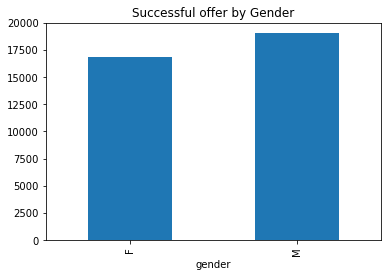

In [126]:
successful_offer_by_gender=master_data.groupby(['gender'])['offer_successfull'].sum()
g=successful_offer_by_gender.plot(kind='bar',title='Successful offer by Gender')
g.set_xticklabels(xlabels)
plt.show()

Male has more successful offer than female that might be because number of male is more than Female.

#### ◼ What is the most succcessful offer?

In [127]:
#calculate success percentage
successful_percent=master_data.groupby(['offer_id'])['offer_successfull'].mean()*100
successful_percent.sort_values(ascending=False)

offer_id
5a8bc65990b245e5a138643cd4eb9837    76.712329
3f207df678b143eea3cee63160fa8bed    73.005858
fafdcd668e3743c1bb461111dcafc2a4    70.249549
2298d6c36e964ae4a3e7e9706d1fb8c2    68.970699
f19421c1d4aa40978ebb69ca19b0e20d    59.002433
4d5c57ea9a6940dd891ad53e9dbe8da0    47.671773
ae264e3637204a6fb9bb56bc8210ddfd    46.850217
9b98b8c7a33c4b65b9aebfe6a799e6d9    38.100224
2906b810c7d4411798c6938adc9daaa5    37.927914
0b1e1539f2cc45b7b9fa7c272da2e1d7    22.405590
Name: offer_successfull, dtype: float64

From above , offer id# 5a8bc65990b245e5a138643cd4eb9837 followed by 3f207df678b143eea3cee63160fa8bed are the most successful offers while offer id #0b1e1539f2cc45b7b9fa7c272da2e1d7 is the least succcessful offer.

#### ◼ What is the average age of starbucks member?

In [138]:
master_data['age'].mean()

54.369257605148796

#### ◼ What is the average income of Starbucks members?

In [139]:
master_data['income'].mean()

65371.61847190268

#### ◼ Age distribution

Text(0.5, 1.0, 'Age Ditribution')

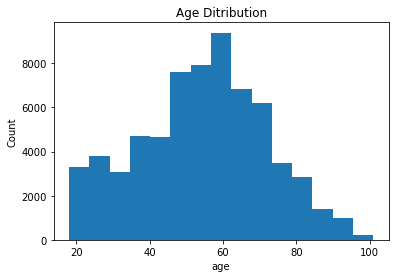

In [140]:
# Age distribution
plt.hist(master_data['age'],bins=15)
plt.xlabel('age')
plt.ylabel('Count')
plt.title('Age Ditribution')

From above most of customer age in range of 40 to 70

## Models

### Create train and test data set

All features are converted to numeric values to fit & train our models

In [141]:
master_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66501 entries, 0 to 53200
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   offer_id            66501 non-null  object 
 1   start_time          66501 non-null  int64  
 2   difficulty          66501 non-null  int64  
 3   duration            66501 non-null  int64  
 4   bogo                66501 non-null  float64
 5   informational       66501 non-null  float64
 6   discount            66501 non-null  float64
 7   reward              66501 non-null  float64
 8   web                 66501 non-null  float64
 9   email               66501 non-null  float64
 10  mobile              66501 non-null  float64
 11  social              66501 non-null  float64
 12  gender              66501 non-null  int64  
 13  age                 66501 non-null  float64
 14  income              66501 non-null  float64
 15  start_month         66501 non-null  int64  
 16  star

In [144]:
#convert offer id to numeric
offer_id_v=master_data['offer_id'].astype('category').cat.categories.tolist()
replace_offer_id = {'offer_id' : {k: v for k,v in zip(offer_id_v,list(range(1,len(offer_id_v)+1)))}}

In [145]:
master_data.replace(replace_offer_id,inplace=True)

In [146]:
master_data

,offer_id,start_time,difficulty,duration,bogo,informational,discount,reward,web,email,mobile,social,gender,age,income,start_month,start_year,transaction_amount,offer_successfull
0,6,7,0,3,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1,33.0,72000.0,4,2017,22.16,1
1,4,14,0,4,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1,33.0,72000.0,4,2017,22.16,1
2,4,0,0,4,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0,40.0,57000.0,1,2018,13.49,1
3,6,14,0,3,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,40.0,57000.0,1,2018,13.49,1
4,6,21,0,3,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,59.0,90000.0,3,2016,27.94,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53196,1,7,20,10,0.0,0.0,1.0,5.0,1.0,1.0,0.0,0.0,0,45.0,62000.0,11,2016,104.20,1
53197,3,14,10,7,0.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0,0,45.0,62000.0,11,2016,104.20,1
53198,3,17,10,7,0.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0,0,45.0,62000.0,11,2016,104.20,0
53199,7,21,5,7,1.0,0.0,0.0,5.0,1.0,1.0,1.0,0.0,0,45.0,62000.0,11,2016,104.20,1


In [147]:
# factors/features that influence the label variable
features = master_data.drop(columns=['offer_successfull'])

# label variable to predict
label = master_data.filter(['offer_successfull'])

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features.values, label.values, test_size=0.3, random_state=42)



X_train = X_train[:, 2:].astype('float64')


X_test = X_test[:, 2:].astype('float64')

# convert train and test labels to array
y_train = y_train.ravel()
y_test = y_test.ravel()



In [148]:
#Display result of the split
print('Result of Split: \n..........')
print('Training set has  {} samples.'.format(X_train.shape[0]))
print('Testing set has  {} samples.'.format(X_test.shape[0]))


Result of Split: 
..........
Training set has  46550 samples.
Testing set has  19951 samples.


#### ◼ Evaluate Naive predictor performance

In [149]:
naive_predict_accuracy=accuracy_score(y_train,np.ones(len(y_train)))
naive_predict_f1score=f1_score(y_train,np.ones(len(y_train)))

print('Naive predictor accuracy is : %.4f'%(naive_predict_accuracy))
print('Naive predictor f1 score is : %.4f'%(naive_predict_f1score))

Naive predictor accuracy is : 0.5399
Naive predictor f1 score is : 0.7012


#### ◼ Logistic Regression Mode

In [150]:

# define a logistic regression classifer object
lr_clf = LogisticRegression(random_state=42, solver='liblinear',max_iter=10000)

# define a params dict to tune the model
grid_params = {
    'penalty': ['l1', 'l2'],
    'C': [1.0, 0.1, 0.01]}
lr_random = GridSearchCV(estimator = lr_clf,param_grid=grid_params) 


# fit train data to the mode
lr_random.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=10000, random_state=42,
                                          solver='liblinear'),
             param_grid={'C': [1.0, 0.1, 0.01], 'penalty': ['l1', 'l2']})

In [151]:
def evaluate_model_performance(clf, X_train, y_train):
    '''
    This function is to evaluate model performace
    
    input: estimator instance , X_train & y_train data
    
    output: clf_accuracy, clf_f1_score
    '''
    class_name = re.sub("[<>']", '', str(clf.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]

    y_pred_rf = clf.predict(X_train)

    clf_accuracy = accuracy_score(y_train, y_pred_rf)
    clf_f1_score = f1_score(y_train, y_pred_rf)
    
    print("%s model accuracy: %.3f" % (class_name, clf_accuracy))
    print("%s model f1-score: %.3f" % (class_name, clf_f1_score))
    
    return clf_accuracy, clf_f1_score

#### Evaluate Train Data Performance

In [152]:
# evaluate logistic regression model's performance
evaluate_model_performance(lr_random.best_estimator_, X_train, y_train)

LogisticRegression model accuracy: 0.753
LogisticRegression model f1-score: 0.778


(0.7528893662728249, 0.777534956582281)

#### Evaluate Test Data Performance

In [153]:
evaluate_model_performance(lr_random, X_test, y_test)

GridSearchCV model accuracy: 0.746
GridSearchCV model f1-score: 0.773


(0.7462783820359882, 0.772861886386072)

#### ◼Random Forest Classifier

In [170]:
# define a random forest classifier object
rf_clf = RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8] 
}
rf_random = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv= 3,
                          verbose=2, n_jobs = 3)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=3,
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]},
             verbose=2)

#### Evaluate Train Data Performance

In [171]:
# evaluate random forest classifier model's performance
evaluate_model_performance(rf_random.best_estimator_, X_train, y_train)

RandomForestClassifier model accuracy: 0.832
RandomForestClassifier model f1-score: 0.851


(0.8320896223755193, 0.8512678776577147)

In [172]:
#find best estimator for randim forest
best_random = rf_random.best_params_
print('best params are : ', best_random)

best params are :  {'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}


#### Model Evaluation and Validation

In [178]:
from sklearn.model_selection import KFold 

In [179]:
kf =KFold(n_splits=5, shuffle=True, random_state=42)

cnt = 1
# split()  method generate indices to split data into training and test set.
for train_index, test_index in kf.split(features, label.values.ravel()):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt += 1

Fold:1, Train set: 53200, Test set:13301
Fold:2, Train set: 53201, Test set:13300
Fold:3, Train set: 53201, Test set:13300
Fold:4, Train set: 53201, Test set:13300
Fold:5, Train set: 53201, Test set:13300


In [180]:
from sklearn.model_selection import cross_val_score

In [181]:
score = cross_val_score(rf_clf, features, label.values.ravel(), cv= kf)
print(f'Scores for each fold are: {score}')

Scores for each fold are: [0.8176077  0.81       0.81736842 0.81218045 0.80796992]


#### Evaluate Test Data Performance

In [182]:
evaluate_model_performance(rf_random.best_estimator_, X_test, y_test)

RandomForestClassifier model accuracy: 0.779
RandomForestClassifier model f1-score: 0.785


(0.7788721804511278, 0.7852500912741875)

### Conclusion

#### Reflection

##### The initial challenge for me was deciding on the problem statement. After exploring the given datasets I've chose to build a model that predict customer responce to the offer by following the below steps:

1. Explore portfolio, profile, transcript datasets , clean them, then combine them. Each row in the combined dataset will have offers attributes, customer demographic data and offer is successful or not.
2. Evaluate the accuracy and F1 score of a naive model which assumes that all offer were sucessful.
3. Compared the performance of logistic regression and random forest models.

I found that random forest model has the best training data accuracy which is (0.832) and F1 score which is (0.851), the test data accuracy is 0.779 and F1 score is 0.785. The random forest model didn't overfit the training data.

#### Improvements

- optimizing the define_offer_successful function since it's took long time to run. 
- Better prediction may have been determined if there were more customer metrics and customer data. In this project we've only limited customer demographic information such as age,gender and income, having more features may help in improving model result.
- Building offer recommendation system which can help the company to find best offer for thier customer based on the demographic data.

#### Refrences

https://www.geeksforgeeks.org/python-pandas-dataframe-shift/#:~:text=shift()%20function%20Shift%20index,dealing%20with%20time%2Dseries%20data.
https://www.askpython.com/python/examples/k-fold-cross-validation